In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plot_post import plot_post

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Comparando grupos (t-test Bayesiano)

Un problema común al analizar datos consiste en comparar dos grupos de datos al hacernos preguntas como, ¿Cúan diferentes son dos grupos? ¿Podemos asegurar, razonablemente, que la diferencia es distinta de cero? ¿Cúan seguros podemos estar de que la diferencia sea tal o cual valor?. Contestar estas preguntas de apariencia trivial rápidamente se vuelve algo sutil, al darnos cuenta que no solo debemos comparar las medias si no que es necesario tener en cuenta la variabilidad de los datos y que siempre que trabajemos con datos reales hay un nivel de incerteza asociado a la medición de esos datos. Como veremos la estadística Bayesiana permite de forma simple y flexible aproximarse a responder a estas preguntas.

Los frecuentistas resuelven este problema mediante lo que se conoce como t-test. Basicamente hacen algunos supuestos como que los datos siguen una distribución normal y luego calculan un estimador o estadístico, resulta que este estimador sigue (bajo ciertos supuestos) una distribución t de Student (de ahí la **t** en **t**-test). 

Nosotros no vamos a hacer esto (ni entrar en detalles de como funciona este método frecuentista). Lo que haremos será usar la distribución t de Student, pero de forma diferente. Nosotros vamos a asumir que son los datos quienes siguen una distribución t de Student con $nu$ (el parámetro que determina la _normalidad_ desconocido). Es decir si los datos así lo indican $nu$ tomará un valor alto y estaremos frente a una distribución prácticamente normal, caso contrario tendremos una curva con colas más largas/gordas que una Gaussiana. En general no será la estimación de $nu$ quien nos interese si no las estimacioens de la media y desviación estandard de cada distribución t (una por cada grupo), que usaremos para entender si difieren y como lo hacen los 2 grupos. 

Como es una análisis Bayesiano será necesario, además especificar los _a prioris_. El modelo general que usaremos será:

<img src="imagenes/BEST.png" width=500>

Es interesante notar, que aunque a primera vista no parezca, este modelo puede ser pensado como un caso especial del modelo generalizado lineal (ver capítulo 5) cuya forma general es:

$$y = \alpha + \beta x + \epsilon$$

Solo que en nuestro caso x es un indicador nominal de pertenencia a un determinado grupo (control-tratamiento, vegano-omnívoro, colectivero-taxista, etc), por lo que el modelo lineal generalizado queda reducido a:

$$y = \alpha_x + \epsilon$$

O expresado de forma probabilística:

$$ y \sim \mathcal{t}(\alpha_x, \sigma, \nu) $$

Vamos a suponer que por alguna extraña razón nos interesa saber si una droga dada tiene efectos en potenciar las capacidades cognitivas en humanos. El experimento consiste en tomar un grupo de personas y realizarles un test de coeficiente intelectual, a la mitad se le administra la droga en cuestión (un cierto tiempo antes de realizar el test) y al resto se les da una placebo. Los datos obtenidos fueron:

In [191]:
y1 = np.array([101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101])  # droga
y2 = np.array([99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99])  # placebo

Siempre que se pueda es buena idea visualizar los datos. Los histogramas, KDEs, boxplots y violinplots, pueden ser usados como un método cualitativo para determinar diferencias entre grupos ya que permiten rápidamente visualizar en simultaneo varias carácterísticas de las distribuciones.

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


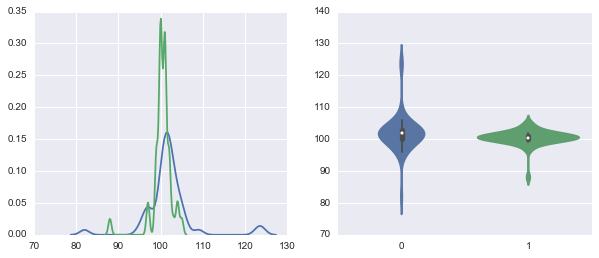

In [192]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.kdeplot(y1)
sns.kdeplot(y2);
plt.subplot(122)
sns.violinplot(data=[y1, y2]);

En el siguiente ejemplo fijaremos _a prioris_ ligeramente informativos que pueden usarse para prácticamente cualquier problema. Como ya dijimos este tipo de _a prioris_ pueden resultar útiles al inicio del modelado de un problema, o cuando realmente no se tiene información sobre el problema, pero  si contamos con información previa entonces seguramente resultará de mucha utilidad incorporarla a nuestro análisis vía los _a prioris_.

In [196]:
with pm.Model() as model:        
    # definimos los a prioris
    grupo1_media = pm.Normal('grupo1_media', mu=np.mean(y1), sd=100)
    grupo2_media = pm.Normal('grupo2_media', mu=np.mean(y2), sd=100)
    grupo1_sd = pm.Uniform('grupo1_sd', lower=0, upper=100)
    grupo2_sd = pm.Uniform('grupo2_sd', lower=0, upper=100)
    nu = pm.Exponential('nu', 1/30)

    # definimos el likelihood
    grupo1 = pm.T('grupo1', nu=nu, mu=grupo1_media, sd=grupo1_sd, observed=y1) # droga
    grupo2 = pm.T('grupo2', nu=nu, mu=grupo2_media, sd=grupo2_sd, observed=y2) # placebo

    dif_medias = pm.Deterministic('dif_medias', grupo1_media - grupo2_media)
    dif_sds = pm.Deterministic('dif_sds', grupo1_sd - grupo2_sd)
    d_cohen = pm.Deterministic('d_cohen', dif_medias / 
                                   pm.sqrt((grupo1_sd**2 + grupo2_sd**2) / 2))

    step = pm.Metropolis()
    trace = pm.sample(10000, step)

 [-----------------100%-----------------] 10000 of 10000 complete in 5.5 sec

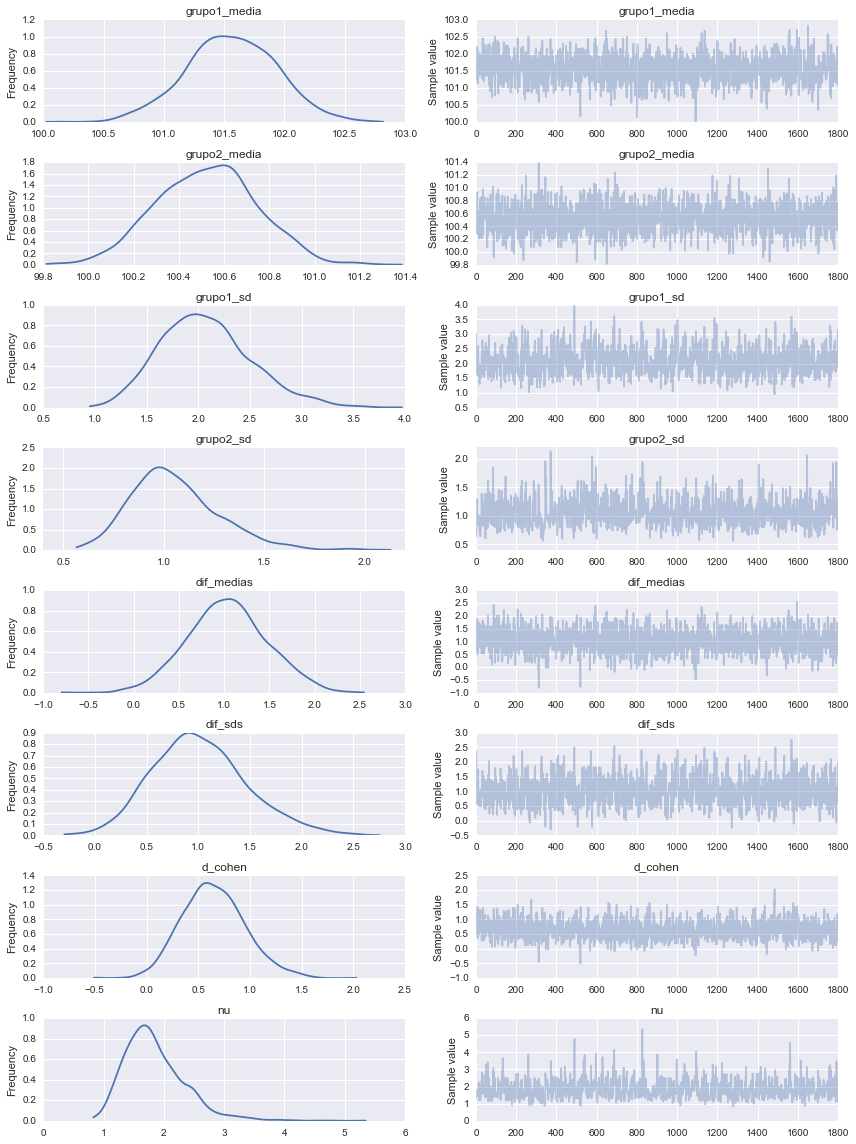

In [197]:
vars=[grupo1_media, grupo2_media, grupo1_sd, grupo2_sd, dif_medias, dif_sds, d_cohen, nu]
cadena = trace[1000::5]
pm.traceplot(cadena, vars=vars);

In [198]:
#pm.plots.summary(cadena, vars=vars)

In [199]:
#pm.autocorrplot(cadena, vars=vars);

In [200]:
#pm.summary(cadena,vars=[efecto])

## Analizando los resultados

Es importante recordar que un análisis bayesiano devuelve la distribución completa de valores creibles (dado los datos y el modelo). Muchas veces resulta conveniente convertir esta distribución continua en decisiones discretas, por ejemplo para contestar la pregunta ¿Son las medias de los grupo diferentes entre si?
En el siguiente gráfico es posible ver que el 98% por cierto de la distribución marginal para el _a posteriori_ de las diferencias de medias está por encima de 0 y que en promedio esa diferencia está alrededor 1. Por lo tanto podemos concluir que lo más probable es que las medias no sean iguales y que es muy probable que la diferencia entre las medias sea de 1, con un HDI95 entre ~0,1 y 1,9.

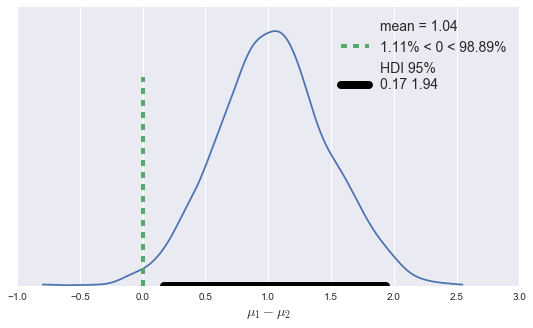

In [201]:
plt.figure(figsize=(9,5))
plot_post(cadena['dif_medias'], show_mode=False, xlab='$\mu_1-\mu_2$', comp_val=0);

Un análisis similar se puede hacer para las diferencias de desviaciones estandard. En el siguiente gráfico se puede ver que la desviación estandard del primer grupo (el que recibió la droga) es superior a la del grupo control. Estos junto con la diferencia entre las medias de los grupos nos estaría diciendo que por un lado la droga es efectiva en promedio para aumentar el IQ, pero que al mismo tiempo introduce mayor dispersión entre los individuos es decir a algunos individuos los afecta negativamente mientras que a otros positivamente.

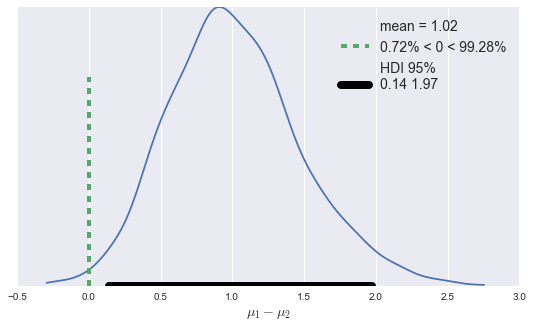

In [202]:
plt.figure(figsize=(9,5))
plot_post(cadena['dif_sds'], show_mode=False, xlab='$\mu_1-\mu_2$', comp_val=0);

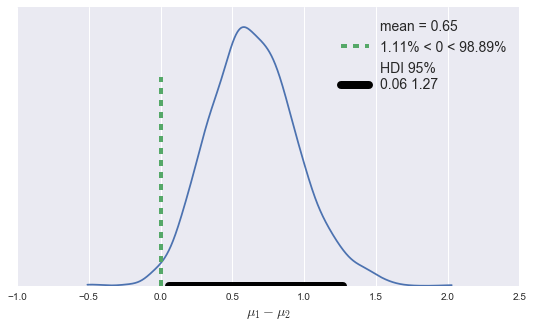

In [203]:
plt.figure(figsize=(9,5))
plot_post(cadena['d_cohen'], show_mode=False, xlab='$\mu_1-\mu_2$', comp_val=0);

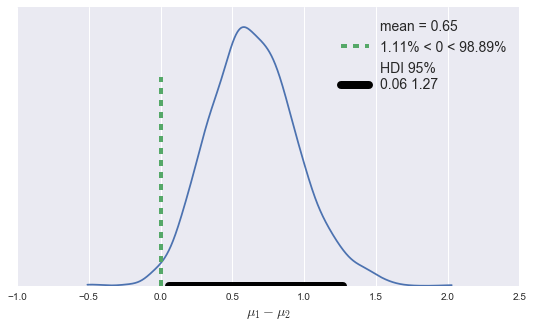

In [204]:
plt.figure(figsize=(9,5))
plot_post(cadena['d_cohen'], show_mode=False, xlab='$\mu_1-\mu_2$', comp_val=0);

Es común que estudios como este terminen en titulares periodísticos del estilo "Descruben droga revolucionaria que haría a la humanidad más inteligente: El fin del cambio climatico, las guerras y el hambre cada vez más cerca".

A fin de tratar de evitar que eso suceda, y _a riesgo_ de que nuestro paper termine publicado en una revista _de no tan buena calidad_, o incluso de encontrar que no hay nada que publicar. Es necesario poner los resultados en contexto, como vimos la droga si tendría un efecto sobre el IQ (dados nuestros datos y el modelo), pero por un lado no todos los individuos se ven igualmente beneficiados y segundo el fecto en promedio es de 1 punto de IQ, un valor que no es realmente alto. Es decir aún cuando el análisis Bayesiano nos dice que los grupos difieren en sus medias y desviaciones estandard, la magnitud con que difieren podría ser considerada marginal o relevante dependiendo del contexto en el que se realizó experimento.

Una forma de formalizar esto es midiendo el tamaño del efecto observado. Existen muchas posibles forma de medir el tamañan de un efecto (el coeficiente de correlación de Person _r_ es una de ellas). Una expresión muy usada cuando se comparan medias es usar lo que se concoe como _d de Cohen_, que se calcula como

$$ \frac{\mu_1 - \mu_2}{\sqrt{\left(\frac{sd_1^2 + sd_2^2}{2}\right)}}$$

Es decir, el tamaño del efecto es calculado como la diferencia de las medias sobre la desviación estandard promedio. Introducir la variabilidad de los grupos (y no solo las medias) es importante, por que como vimos antes, un aumento o disminución que en promedio es de $x$ unidades puede ser explicado como que todos los individuos cambiaron exactamente $x$, o que la mitad cambio 0 y la otra mitad $2x$ (u otras combinaciones). Por lo tanto tener en cuenta la variabilidad de ambos grupos es crucial. 

El tamaño del efecto calculado de esta se puede interpretar como un _Z-score_ (asumiendo normalidad). Por ejemplo un efecto de 0.6 quiere decir que la respuesta promedio obtenida en el tratamiento está 0.65 desviaciones estandard por encima que la repuesta promedio en el grupo control.

Otro detalla a tener en cuenta es que, dado que nuestro cálculo es bayesiano, el _tamaño del efecto_ es computado a partir del _a posteriori_, es decir para cada punto de la hipersuperficie del _a posteriori_ calculamos el tamaño del efecto, obteniendo la distribución de valores más probables (dado los datos y el modelo). En la literatura el d de cohen se calcula usando un promedio pesado (según la cantidad de datos en cada grupo) para estimar la desviacion estandard promedio. Este promedio pesado, bajo el supuesto de igualdad de varianzas para ambas poblaciones, permite estimar con mayor precisión la varianza, que usar cualquiera de las dos varianzas. Dado que nosotros computamos el d de cohen como parte de la inferencia Bayesiana (es decir a partir del _a posteriori_), no es necesario hacer correcciones segun el tamaño de la muestra.

## Probability of superiority
This is effect size with many names: common language effect size (CL), Area under the receiver operating characteristics (AUC) or just A for its non-parametric version (Ruscio & Mullen, 2012). It is meant to be more intuitive for persons without any training in statistics. The effect size gives the probability that a person picked at random from the treatment group will have a higher score than a person picked at random from the control group. Cohen's d can be converted CL using the following formula (Ruscio, 2008)
CL=Φ(δ2√)

http://www.leeds.ac.uk/educol/documents/00002182.htm

## Posterior predictive check

dibujar distribuciones t sobre el histograma del grupo 1 por un lado y del grupo 2 por el otro.

## ejercicios

Para el siguiente conjunto de datos repetir el análisis antes realizado.

1) Muestra _pequeña_ tomada de una distribución normal standard.

    y1 = [0.99, 0.35, 1.14, 1.65, 1.04, -0.46, 2.93, 2.35]
    y2 = [-1.25, -0.19, -0.42, 1.80, 0.90,  0.68, -1.31, -0.20]

1) Muestra _grande_ tomada de una distribución normal standard.

    y1 = np.random.normal(size=1000)
    y2 = np.random.normal(size=1000)

## Para seguir leyendo

* Más sobre t-test:
    * Este capítulo está basado en la publicación: [Bayesian estimation supersedes the t test. Journal of Experimental Psychology. Kruschke, John. (2012)](www.indiana.edu/~kruschke/BEST/BEST.pdf). Esta publicación incluye una detallada comparación entre el clásico _t-test_ y su versión Bayesiana y las razones para preferir esta última.
    * Capítulos 15-16 de Doing Bayesian Data Analysis de Kruschke (2 [edición](www.amazon.com/gp/product/0124058884))

* Material online con tópicos Bayesianos:
    * [Publishable Stuff](http://sumsar.net/)
    * [Probably Overthinking It](http://allendowney.blogspot.com.ar/)
    * [Pythonic Perambulations](http://jakevdp.github.io./)
    * [While My MCMC Gently Samples](http://twiecki.github.io/)
    * [Count Bayesie](https://www.countbayesie.com/)
    * [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/#contents)   


* Las plantillas utilizadas para generar los diagramas de Kruschke, fueron creadas por [Rasmus Bååth's](http://sumsar.net/blog/2013/10/diy-kruschke-style-diagrams/)
* El código es una modificación del [modelo portado a PyMC3](http://pymc-devs.github.io/pymc3/BEST/) desde R por Thomas Wiecki.

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("Esta notebook fue creada en una computadora %s corriendo %s y usando:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))